In [ ]:
import glob
import numpy as np
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.models.segmentation.deeplabv3 import DeepLabV3_ResNet50_Weights
import torchvision.models as models
from pathlib import Path
import torch
import gc
from matplotlib import pyplot as plt
from pathlib import Path
import os
import geopandas as gpd
import pandas as pd
from skimage import measure
from shapely.geometry import Polygon, mapping
from osgeo import gdal, gdalconst
import glob

In [ ]:
!pip install rasterio geojson
import rasterio
import geojson
from rasterio.transform import Affine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 48.8 MB/s eta 0:00:00


In [ ]:
# # Make grid
# original_size=11
# x_list = np.array([i for i in range(np.round(original_size/4).astype(int))])
# y_list = np.array([i for i in range(np.round(original_size/4).astype(int))])
# X, Y = np.meshgrid(x_list,y_list)
# XY = np.stack((X, Y), axis=-1).flatten().reshape(-1, 2)
# input_img = np.ones((original_size,original_size,3))*0
# # Calculate the x and y difference for padding
# dif_y = (np.round(original_size/4)*4-original_size).astype(int)
# dif_x = (np.round(original_size/4)*4-original_size).astype(int)

# # Create a bigger matrix to place the input image in the center
# padding = 2
# matrix_ones = np.ones((original_size+padding*2+dif_y, original_size+padding*2+dif_x, 3))*255.0  # Create a ones matrix with a bigger size than the input image (-256, 256)
# matrix_ones[padding:padding+original_size, padding:padding+original_size, :] = input_img  # Place the input image in the center of the matrix

# q_list = [[1,1,1,1],[0,0,0,0],[2,2,0,0],[0,0,2,2],[2,2,2,2]]
# final_output_list = []

# fig, axis = plt.subplots(8,1,figsize=(5,25))
# for q_idx, q in enumerate(q_list):
#     matrix_zeros_output = np.zeros((original_size+padding*2+dif_y, original_size+padding*2+dif_x, 1)) # Create a zeros matrix with a bigger size than the input image (-256, 256)
#     for idx, (x0, y0) in enumerate(XY):
#       img_pos = np.array([x0, y0])
#       x_start = img_pos[0]*4 + q_list[q_idx][0]*padding
#       x_end = (img_pos[0]+1)*4 + q_list[q_idx][1]*padding
#       y_start = img_pos[1]*4 + q_list[q_idx][2]*padding
#       y_end = (img_pos[1]+1)*4 + q_list[q_idx][3]*padding
#       input_img_slice = matrix_ones[x_start:x_end, y_start:y_end,:]
#       # print(f"x: {x_start}:{x_end}", f"y: {y_start}:{y_end}")
#       # print(idx)
#       matrix_zeros_output[x_start:x_end, y_start:y_end,:] += np.ones((4,4,1))*255/5
#     final_output_list.append(matrix_zeros_output)
#     axis[q_idx].imshow(matrix_zeros_output)
# final_output = np.sum(final_output_list,axis=0)
# axis[5].imshow(final_output)
# final_output[padding:(padding+original_size+dif_y),padding:(padding+original_size+dif_x),:] /= 2
# final_output[:,padding*2:(original_size+dif_x),:] *=(2/3)
# final_output[padding*2:(original_size+dif_y),:,:] *=(2/3)
# final_output[padding*2:(original_size+dif_y),padding*2:(original_size+dif_x),:] *=(9/10)
# axis[6].imshow(final_output)
# extracted_output = final_output[padding:(padding+original_size), padding:(padding+original_size), :]
# axis[7].imshow(extracted_output)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Models
- #### Unet

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding="same"),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding="same"),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
                )

    def forward(self, x):
        return self.double_conv(x)

class Encoder_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        return self.maxpool_conv(x)

class Decoder_block(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    def forward(self, x1, x2):
        # diff_y = (x2.shape[3] - x1.shape[3]) == 0  # Height difference
        # diff_x = (x2.shape[2] - x1.shape[2]) == 0  # Width difference
        # if not (diff_y and diff_x):
        #   x2 = x2[:,:,0:x1.shape[2],0:x1.shape[3]]
        x = torch.cat([x2, x1], dim=1)
        x = self.up(x)
        return self.conv(x)

class DoubleConvOut(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same"),
                nn.BatchNorm2d(out_channels),
                nn.Sigmoid())

    def forward(self, x):
        return self.double_conv(x)



class UNet(nn.Module):
    # "Almost" symmetric U-Net architecture
    def __init__(self, input_channels, bilinear=True):
        super().__init__()
        self.n_channels = input_channels
        self.bilinear = bilinear


        self.down1 = Encoder_block(self.n_channels, 64)
        self.down2 = Encoder_block(64, 128)
        self.down3 = Encoder_block(128, 256)
        self.inc = DoubleConv(256, 512)
        self.up1 = Decoder_block(512+256, 256, bilinear)
        self.up2 = Decoder_block(256+128, 128, bilinear)
        self.up3 = Decoder_block(128+64,64, bilinear)
        self.inc2 = DoubleConv(64,3)
        self.out = DoubleConvOut(3,1)


    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.inc(x3)
        x5 = self.up1(x4, x3)
        x6 = self.up2(x5, x2)
        x7 = self.up3(x6, x1)
        x8 = self.inc2(x7)
        x9 = self.out(x8)
        return x9
# model = UNet(input_channels=3,bilinear=True).to(device)
# print(model)

- #### DeeplabV3 (DEFAULT)
- Torchvision already has a pre-trained DeepLabV3 model with ResNet50 backbone. However, the classifier layer of the model (the layer before the activation function) is a convolutional layer with 3 output channels. In our case, we want to have a single output channel for binary classification (forest vs non-forest), so we will replace the last layer with a Conv2d layer that has 1 output channel.

In [ ]:
class Deeplabv3(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()


        self.deeplab = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        # One class(forest/non-forest)
        self.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

        self.out = nn.Sigmoid()

    def forward(self, x):
        x1 = self.deeplab(x)['out']
        out = self.out(x1)
        return out

- #### DeeplabV3 (trained backbone + finetuned model)
- I have previously trained my own backbone and performed finetuning, the following model class is used to load the finetuned model.
- I have messed up the name of the blocks during the backbone training, and I have no idea how to rename it, so I defined a finetuning model class based on the original Deeplabv3 model class.

In [ ]:
# The finetuning model class depends on the original Deeplabv3 class, so I copy it here:
class Deeplabv3(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.deeplab = models.segmentation.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        # One class(forest/non-forest)
        self.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

        self.out = nn.Sigmoid()

    def forward(self, x):
        x1 = self.deeplab(x)['out']
        out = self.out(x1)
        return out


# The following class requires the previous class to be defined.
class Finetuning_Deeplabv3(nn.Module):
    def __init__(self):
        super().__init__()
        self.deeplab = Deeplabv3()
        self.deeplab.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.deeplab(x)
        return x

## Prediction
##### 1) If you have multiple smaller images in png/jpg/tiff format, use method 1
##### 2) If you have a large tiff image, use method 2

### Method 1 ------------------------------------------------------------------------------------------------------------------------------------
### Define paths
- model_path: path to the chosen model (Directory + Chosen model name).
- data_path: dir where the input images and their georeferences are stored (Directory only)
- pred_output_path: dir where the output images will be stored (Directory only)
- composite_img_name: path to the merged output image (Dir where the output will be stored + output image name)

In [ ]:
# Path to the trained model
model_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Weights/deeplab_input_512x512_with_val/DeeplabV3_jordan_0.8516221046447754_0.8537178039550781_12.pt")

# Path to the input images
data_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Cantabria_ortofotos/Cantabria_200x200")
data_type = "png"  # Specify the type of images to process, e.g., "png", "jpg", etc.

# Path to save the prediction images
pred_output_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Cantabria_predictions/deeplab_512_200_val_epoch12")

# Output image name
composite_img_name = "512_200_val_epoch12.tif"

### Dataset class
- The following class will keep a list of all the images in the data_path directory. One can access the images by specifying the index of the image in the list, the PredDataset class will apply the necessary transformations to the images:
    - Resize (512,512)
    - Normalization (divided by 255)
    - Conversion to tensor format (from height,width,channel to channel,height,width)
- The images will be returned as pytorch tensors ready for input into the model.

In [ ]:
class PredDataset(Dataset):
    def __init__(self, data_path, img_type):

        # root directory for the images
        self.data_path = data_path
        img_path_list = []

        # Collect all image paths with the specified image type
        for root, _, filenames in os.walk(data_path):
            for filename in filenames:
                if filename.endswith(img_type):
                    img_path_list.append(os.path.join(root, filename))
        self.img_path_list = img_path_list


    def __getitem__(self, index):
        # Function to get the image at a specific index
        img = np.array(cv2.imread(self.img_path_list[index]))

        # Transform the image to the required format
        img = cv2.resize(img, (512, 512))
        img = torch.tensor(np.transpose(img,(2,0,1)),dtype=torch.uint8)
        img = img.float() / 255.0

        img_name = os.path.basename(self.img_path_list[index])

        return img, img_name

    def __len__(self):
        return len(self.img_path_list)

### Checking
- This is a section to check that everything is fine

In [ ]:
# Load the dataset
imgs = PredDataset(data_path,data_type)
dataloader = DataLoader(imgs, batch_size=1,drop_last=True,shuffle=True, num_workers=0)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Model initialization
model = Finetuning_Deeplabv3().to(device)
model.load_state_dict(torch.load(model_path, map_location="cpu")["model_state_dict"])
model.eval()

shape = (512, 512)  # Original shape of the input images
for idx, (X, name) in enumerate(dataloader):
    img_name = name[0]
    print(img_name)
    input_tensor = X.to(device)  # Move the input tensor to the GPU
    output = model(input_tensor)
    threshold = 0.5 # The last layer is a sigmoid activation, so we can use a threshold to binarize the output
    output_bin = np.where(np.transpose(output.cpu().detach().numpy()[-1],(1,2,0))>=threshold,1,0)*255.0
    output_bin = cv2.resize(output_bin, shape, interpolation=cv2.INTER_LINEAR)  # Upsample the output to the original size
    break


# Uncomment the following lines to visualize the input and output images

# fig, axis = plt.subplots(1, 2, figsize=(5, 5))
# axis[0].imshow(np.transpose(input_tensor.cpu().detach().numpy()[0],(1,2,0)),cmap='gray')
# axis[0].set_title("Input Image")
# axis[1].imshow(output_bin)
# axis[1].set_title("Predicted Mask")

### Prediction and export results

In [ ]:
# Model
model.load_state_dict(torch.load(model_path, map_location=device)["model_state_dict"])
model.eval()  # Set the model to evaluation mode

# Dataset
data_type = "png" # Extension of the image files: png, jpg, tiff, etc.
shape = (1024,1024) # Original shape of the input images
cantabria = PredDataset(data_path,data_type) # Create the dataset object
cantabria_dataloader = DataLoader(cantabria, batch_size=1) # Create the dataloader object

threshold = 0.5
num_img = len(cantabria_dataloader)
for idx, (X, name) in enumerate(cantabria_dataloader):
    img_name = name[0]
    input_tensor = X.to(device)  # Move the input tensor to the GPU
    output = model(input_tensor)
    output_bin = np.where(np.transpose(output.cpu().detach().numpy()[-1],(1,2,0))>=threshold,1,0)*255.0
    # Upsample the output to the original size
    output_bin = cv2.resize(output_bin, shape, interpolation=cv2.INTER_LINEAR)

    # Save the output as an image
    with open(pred_output_path / img_name, 'wb') as f:
        cv2.imwrite(f.name, output_bin)
    if idx%(num_img//10)==0:
        print(f"Progress: {idx}/{num_img} images processed.")


torch.cuda.empty_cache()
gc.collect()

### If you want to merge images, you need their georeferences. If want to do the prediction without merging you can skip this part.
- Copy georeferences

In [ ]:
# # Pass the pgw files to the output images dir
# for root,_,filenames in os.walk(data_path):
#     for filename in filenames:
#         if filename.endswith(".pgw"):
#             pgw_file = os.path.join(root, filename)
#             new_pgw_file = os.path.join(pred_output_path, filename)
#             with open(new_pgw_file, 'wb') as f:
#                 f.write(open(pgw_file, 'rb').read())

- Merge

In [ ]:
# file_type = "png"
# png_files = glob.glob(str(pred_output_path) + "/*." + file_type)
# gdal.Warp(composite_img_name,png_files,format="GTiff",multithread=True)

### Method 2 ------------------------------------------------------------------------------------------------------------------------------------
- To use this method, you need to have a large tiff image.

### Define paths
- The only difference is the data_path, in the previous method, data_path is the directory where you keep your input images. Here, data_path (input_img_path) is the path to the large tiff image (directory + name).

In [ ]:
# Path to the trained model
model_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Weights/deeplab_input_512x512_with_val/DeeplabV3_jordan_0.8975734710693359_0.863532543182373_23.pt")

# Path to the input images
input_img_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Cantabria_merged_pred/ortofoto_200.tif")

# Output image name
composite_img_name = "512_200_val_epoch23.tif"

### Setup

In [ ]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deeplabv3().to(device)
model.load_state_dict(torch.load(model_path, map_location=device)["model_state_dict"])
model.eval()

# Prediction image
input_img = cv2.imread(input_img_path)

# Get metadata
ds = gdal.Open(input_img_path)
gt = ds.GetGeoTransform()



# Calculate the x and y difference for padding
dif_y = (np.round(input_img.shape[0]/1024)*1024-input_img.shape[0]).astype(int)
dif_x = (np.round(input_img.shape[1]/1024)*1024-input_img.shape[1]).astype(int)

# Make grid
x_list = np.array([i for i in range(np.round(input_img.shape[0]/1024).astype(int))])
y_list = np.array([i for i in range(np.round(input_img.shape[1]/1024).astype(int))])
X, Y = np.meshgrid(x_list,y_list)
XY = np.stack((X, Y), axis=-1).flatten().reshape(-1, 2)


# Create a bigger matrix to place the input image in the center
padding = 256
matrix_ones = np.ones((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 3))*255.0  # Create a ones matrix with a bigger size than the input image (-256, 256)
matrix_zeros_output = np.zeros((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 1)) # Create a zeros matrix with a bigger size than the input image (-256, 256)
matrix_ones[padding:padding+input_img.shape[0], padding:padding+input_img.shape[1], :] = input_img  # Place the input image in the center of the matrix
print("input image shape: ", input_img.shape)
print("matrix_ones shape(+-256): ", matrix_ones.shape)
print("grid shape:", np.round(input_img.shape[0]/1024), "x", np.round(input_img.shape[1]/1024))
print("transform: ", gt)


NameError: name 'Finetuning_Deeplabv3' is not defined

### Prediction

In [ ]:
for idx, (x0, y0) in enumerate(XY):
    print(f"Processing image position: {idx+1}/{XY.shape[0]} - ({x0}, {y0})")
    # Image position:
    img_pos = np.array([x0, y0])
    input_img_slice_centered = matrix_ones[img_pos[0]*1024+padding:(img_pos[0]+1)*1024+padding, img_pos[1]*1024+padding:(img_pos[1]+1)*1024+padding,:]
    input_img_slice_q1 = matrix_ones[img_pos[0]*1024:(img_pos[0]+1)*1024, img_pos[1]*1024:(img_pos[1]+1)*1024,:]
    input_img_slice_q2 = matrix_ones[img_pos[0]*1024+padding*2:(img_pos[0]+1)*1024+padding*2, img_pos[1]*1024:(img_pos[1]+1)*1024,:]
    input_img_slice_q3 = matrix_ones[img_pos[0]*1024:(img_pos[0]+1)*1024, img_pos[1]*1024+padding*2:(img_pos[1]+1)*1024+padding*2,:]
    input_img_slice_q4 = matrix_ones[img_pos[0]*1024+padding*2:(img_pos[0]+1)*1024+padding*2, img_pos[1]*1024+padding*2:(img_pos[1]+1)*1024+padding*2,:]
    input_img_qlist = [input_img_slice_q1, input_img_slice_q2, input_img_slice_q3, input_img_slice_q4,input_img_slice_centered]

    # Output prediction for each quadrant
    for idx, input_img_slice in enumerate(input_img_qlist):
        # Resize and normalize the input image slice
        # print(input_img_slice.shape)
        input_img_slice = cv2.resize(input_img_slice, (512, 512))/255.0
        # Convert to tensor and move to device
        input_img_slice = torch.tensor(np.transpose(input_img_slice, (2, 0, 1)), dtype=torch.float32)
        # Add batch dimension and move to device
        input_img_slice = input_img_slice.unsqueeze(0).to(device)

        # Prediction
        output = model(input_img_slice)
        output = np.transpose(output.cpu().detach().numpy()[-1], (1, 2, 0))
        output = np.expand_dims(cv2.resize(output, (1024, 1024), interpolation=cv2.INTER_LINEAR), axis=-1)  # Resize the output to 1024x1024 and add a new axis for the channel
        if idx == 0:
            matrix_zeros_output[img_pos[0]*1024:(img_pos[0]+1)*1024, img_pos[1]*1024:(img_pos[1]+1)*1024, :] += output
        elif idx == 1:
            matrix_zeros_output[img_pos[0]*1024+padding*2:(img_pos[0]+1)*1024+padding*2, img_pos[1]*1024:(img_pos[1]+1)*1024, :] += output
        elif idx == 2:
            matrix_zeros_output[img_pos[0]*1024:(img_pos[0]+1)*1024, img_pos[1]*1024+padding*2:(img_pos[1]+1)*1024+padding*2, :] += output
        elif idx == 3:
            matrix_zeros_output[img_pos[0]*1024+padding*2:(img_pos[0]+1)*1024+padding*2, img_pos[1]*1024+padding*2:(img_pos[1]+1)*1024+padding*2, :] += output
        else:
            # centered image
            output_centered = output


    # Normalize horizontal component
    matrix_zeros_output[img_pos[0]*1024:(img_pos[0]+1)*1024+padding*2, img_pos[1]*1024+padding*2:(img_pos[1]+1)*1024,:] /= 2
     # Normalize vertical component
    matrix_zeros_output[img_pos[0]*1024+padding*2:(img_pos[0]+1)*1024, img_pos[1]*1024:(img_pos[1]+1)*1024+padding*2,:] /= 2

    # Add the centered output to the matrix and normalize it
    matrix_zeros_output[img_pos[0]*1024+padding:(img_pos[0]+1)*1024+padding, img_pos[1]*1024+padding:(img_pos[1]+1)*1024+padding,:] += output_centered
    matrix_zeros_output[img_pos[0]*1024+padding:(img_pos[0]+1)*1024+padding, img_pos[1]*1024+padding:(img_pos[1]+1)*1024+padding,:] /= 2

    # With/without threshould (and remove padding)
final_output = np.where(matrix_zeros_output> 0.5, 1, 0)[padding:(padding+input_img.shape[0]), padding:(padding+input_img.shape[1]), :]



Processing image position: 1/130 - (0, 0)
Processing image position: 2/130 - (1, 0)
Processing image position: 3/130 - (2, 0)
Processing image position: 4/130 - (3, 0)
Processing image position: 5/130 - (4, 0)
Processing image position: 6/130 - (5, 0)
Processing image position: 7/130 - (6, 0)
Processing image position: 8/130 - (7, 0)
Processing image position: 9/130 - (8, 0)
Processing image position: 10/130 - (9, 0)
Processing image position: 11/130 - (0, 1)
Processing image position: 12/130 - (1, 1)
Processing image position: 13/130 - (2, 1)
Processing image position: 14/130 - (3, 1)
Processing image position: 15/130 - (4, 1)
Processing image position: 16/130 - (5, 1)
Processing image position: 17/130 - (6, 1)
Processing image position: 18/130 - (7, 1)
Processing image position: 19/130 - (8, 1)
Processing image position: 20/130 - (9, 1)
Processing image position: 21/130 - (0, 2)
Processing image position: 22/130 - (1, 2)
Processing image position: 23/130 - (2, 2)
Processing image pos

### Prediction and export results (geotiff format)

In [ ]:
# export the final image
print(np.max(final_output),np.min(final_output))
print(final_output.shape)
final_output_255 = final_output*255
print(np.max(final_output_255),np.min(final_output_255))
print(final_output_255.shape)

# Save the output as an image
pred_output_path = Path("./")
output_img_name = composite_img_name

with open(pred_output_path / output_img_name, 'wb') as f:
    cv2.imwrite(pred_output_path / output_img_name, final_output_255.astype(np.uint8))

1 0
(10231, 13300, 1)
255 0
(10231, 13300, 1)


In [ ]:
ds2 = gdal.Open(pred_output_path / output_img_name)
ds2.SetGeoTransform(gt)
ds2.SetProjection(ds.GetProjection())
ds2.FlushCache()
ds2 = None  # Close the dataset to save changes

### Convert geotiff to geojson (using cv2.findContours)

In [ ]:


# image path
img_tif_path = Path("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Cantabria_merged_pred/512_200_val_epoch12.tif")

# Load tiff
with rasterio.open(img_tif_path) as src:
    mask = src.read(1)  # read first band
    transform = src.transform  # Affine transform: maps pixel -> world coords

# Check if mask is binary (0 or 1)
binary_mask = (mask > 0).astype(np.uint8) * 255  # values 0 or 255



# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(transform)

# Convert contours to polygons and create GeoJSON features
features = []
for contour in contours:
    pixel_coords = contour.squeeze()  # shape: (N, 2)
    if len(pixel_coords.shape) != 2 or pixel_coords.shape[0] < 3:
        continue  # skip invalid polygons
    # Convert pixel coordinates to geographic using raster transform
    geo_coords = [rasterio.transform.xy(transform, y, x, offset="center") for x, y in pixel_coords]

    # Create polygon
    polygon = Polygon(geo_coords)

    if polygon.is_valid and not polygon.is_empty:
        feature = geojson.Feature(geometry=mapping(polygon))
        features.append(feature)



# export
feature_collection = geojson.FeatureCollection(features)
# Add prop:"value 0" to each feature
for feature in feature_collection["features"]:
    feature["properties"] = {"prop0": "Tree"}

with open(str(img_tif_path).split(".")[0]+"/"+".geojson", "w") as f:
    geojson.dump(feature_collection, f)


### Convert geotiff to csv  (using cv2.findContours)

In [ ]:
import rasterio
import numpy as np
from shapely.geometry import Polygon, mapping, LinearRing
import geojson
from rasterio.transform import Affine
from pathlib import Path
from shapely.ops import unary_union
from shapely.prepared import prep
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS


img_tif_path = Path("/content/drive/MyDrive/ML/Cantabria/Cantabria_3000_MaskMerged/DeeplabV3_jordan_epoch9.tif")

# Load tiff
with rasterio.open(img_tif_path) as src:
    mask = src.read(1)  # read first band
    transform = src.transform  # Affine transform: maps pixel -> world coords

# Check if mask is binary (0 or 1)
binary_mask = (mask > 0).astype(np.uint8) * 255  # values 0 or 255


# Find contours
contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP , cv2.CHAIN_APPROX_SIMPLE)

polygons = []
used_as_hole = set()

for i, contour in enumerate(contours):
    if hierarchy[0][i][3] == -1:  # No parent: it's an outer contour
        contour = contour.squeeze()  # shape: (N, 2)
        if len(contour.shape) != 2 or contour.shape[0] < 3:
            continue
        shell = [rasterio.transform.xy(transform, y, x, offset="center") for x,y in contour]
        shell_poly = Polygon(shell)
        prepared_shell = prep(shell_poly)

        holes = []
        for j, child in enumerate(contours):
            if hierarchy[0][j][3] == i:  # Child of contour i
                child = child.squeeze()
                hole_coords = [rasterio.transform.xy(transform, y, x, offset="center") for x,y in child]
                hole_ring = LinearRing(hole_coords)

                if prepared_shell.contains(Polygon(hole_ring)):
                    holes.append(hole_coords)
                    used_as_hole.add(j)

        polygon = Polygon(shell, holes)
        polygons.append(polygon)





gdf = gpd.GeoDataFrame({"geometry": polygons},crs=25830)
gdf.to_crs(epsg=4326, inplace=True)  # Set the coordinate reference system to WGS84
gdf.to_csv("/content/drive/MyDrive/ML/Coordinates/deeplabv3_epoch9.csv")


# poly = Polygon(shell = [(-4, 43), (-4, 50),(3,50), (3, 43), (-4,43)], holes = [[(-3, 46), (-3, 48), (0, 48), (0, 46)],[(1, 46), (1, 48), (2, 48), (2, 46), (1, 46)]])  # Example polygon
# gdf = gpd.GeoDataFrame({"geometry": [poly]}, crs=4326)
# gdf.to_csv("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Coordinates/test.csv")


IsADirectoryError: [Errno 21] Is a directory: '/content/drive/MyDrive/ML/Coordinates'

### Convert geotiff to csv (using scikit-image-find_contours)

In [ ]:
from skimage import measure
from shapely.geometry import Polygon
from shapely.prepared import prep
from shapely.ops import unary_union

def contours_to_polygons_with_holes(binary_image):
    # Find contours using skimage
    raw_contours = measure.find_contours(image = binary_image, fully_connected="high",positive_orientation="high")

    # Convert to shapely polygons
    polygons = []
    for c in raw_contours:
        # Convert (row, col) -> (x, y)
        coords = [rasterio.transform.xy(transform, x, y, offset="center") for x, y in c]
        poly = Polygon(coords)
        if poly.is_valid and poly.area > 0:
            polygons.append(poly)

    # Classify polygons as outers or holes using prepared.contains
    outers = []
    holes_by_outer = {}

    for i, outer in enumerate(polygons):
        outer_prep = prep(outer)
        is_hole = False
        for j, other in enumerate(polygons):
            if i == j:
                continue
            if prep(other).contains(outer):
                # outer is actually a hole inside 'other'
                holes_by_outer.setdefault(other, []).append(outer)
                is_hole = True
                break
        if not is_hole:
            outers.append(outer)

    # Step 4: Construct final polygons with holes
    final_polygons = []
    for outer in outers:
        holes = [h.exterior.coords[:] for h in holes_by_outer.get(outer, [])]
        polygon = Polygon(shell=outer.exterior.coords[:], holes=holes)
        if not polygon.is_valid:
            polygon = polygon.buffer(0)
        final_polygons.append(polygon)

    return final_polygons

polygons = contours_to_polygons_with_holes(binary_mask)
gdf = gpd.GeoDataFrame({"geometry": polygons}, crs=25830)
gdf.to_crs(epsg=4326, inplace=True)  # Set the coordinate reference system to WGS84
gdf.to_csv("C:/Users/a940926/CHEN/Example-20250407T061515Z-001/Coordinates/512_200_val_epoch12.csv")

NameError: name 'binary_mask' is not defined

### Final functions

In [ ]:
# If using png/jpg + png:
def get_transform_from_pgw(pgw_path):
    with open(pgw_path, 'r') as f:
        lines = f.readlines()
        pixel_size_x = float(lines[0].strip())
        rotation_x = float(lines[1].strip())
        rotation_y = float(lines[2].strip())
        pixel_size_y = float(lines[3].strip())
        top_left_x = float(lines[4].strip())
        top_left_y = float(lines[5].strip())
    return (top_left_x, pixel_size_x, rotation_x, top_left_y, rotation_y, pixel_size_y)
# -------------------------------------------------------------------------
def predict_export(model = Deeplabv3(), model_path=None, input_img_path=None,output_mask_path=None, composite_img_name = None, input_img_type="png"):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.load_state_dict(torch.load(model_path, map_location=device)["model_state_dict"])
  model.to(device)
  model.eval()

  # Prediction image
  input_img = cv2.imread(input_img_path)

  # Get metadata
  if input_img_type == "tif":
    ds = gdal.Open(input_img_path)
    gt = ds.GetGeoTransform()
  elif input_img_type in ["png", "jpg"]:
    # If using png/jpg + pgw, get the transform from the pgw file
    pgw_path = str(input_img_path).replace(input_img_type, "pgw")
    gt = get_transform_from_pgw(pgw_path)



  # Calculate the x and y difference for padding
  dif_y = (np.round(input_img.shape[0]/1024)*1024-input_img.shape[0]).astype(int)
  dif_x = (np.round(input_img.shape[1]/1024)*1024-input_img.shape[1]).astype(int)

  # Make grid
  x_list = np.array([i for i in range(np.round(input_img.shape[0]/1024).astype(int))])
  y_list = np.array([i for i in range(np.round(input_img.shape[1]/1024).astype(int))])
  X, Y = np.meshgrid(x_list,y_list)
  XY = np.stack((X, Y), axis=-1).flatten().reshape(-1, 2)

  # Create a bigger matrix to place the input image in the center
  padding = 256
  matrix_ones = np.ones((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 3))*255.0  # Create a ones matrix with a bigger size than the input image (-256, 256)
  matrix_ones[padding:padding+input_img.shape[0], padding:padding+input_img.shape[1], :] = input_img  # Place the input image in the center of the matrix


  q_list = [[1,1,1,1],[0,0,0,0],[2,2,0,0],[0,0,2,2],[2,2,2,2]]
  matrix_zeros_output_list = []
  # Prediction (better)

  for q_idx, q in enumerate(q_list):
    matrix_zeros_output = np.zeros((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 1)) # Create a zeros matrix with a bigger size than the input image (-256, 256)
    for idx, (x0, y0) in enumerate(XY):
      img_pos = np.array([x0, y0])

      x_start = img_pos[0]*1024 + q_list[q_idx][0]*padding
      x_end = (img_pos[0]+1)*1024 + q_list[q_idx][1]*padding
      y_start = img_pos[1]*1024 + q_list[q_idx][2]*padding
      y_end = (img_pos[1]+1)*1024 + q_list[q_idx][3]*padding


      if idx%50==0 and q_idx==4:
        print(f"Processing image position: {idx+1}/{XY.shape[0]} - ({x0}, {y0})")
      input_img_slice = matrix_ones[x_start:x_end, y_start:y_end,:]
      torch.cuda.empty_cache()
      gc.collect()
      input_img_slice = cv2.resize(input_img_slice, (512, 512))/255.0
      # Transpose and convert to tensor
      input_img_slice = torch.tensor(np.transpose(input_img_slice, (2, 0, 1)), dtype=torch.float32)
      # Add batch dimension and move to device
      input_img_slice = input_img_slice.unsqueeze(0).to(device)
      # Prediction
      output = model(input_img_slice)
      output = np.transpose(output.cpu().detach().numpy()[-1], (1, 2, 0))
      output = np.expand_dims(cv2.resize(output, (1024, 1024), interpolation=cv2.INTER_LINEAR), axis=-1)
      matrix_zeros_output[x_start:x_end, y_start:y_end,:] += output
    matrix_zeros_output_list.append(matrix_zeros_output)


  # normalization
  final_output = np.sum(np.array(matrix_zeros_output_list),axis=0)
  final_output[padding:(padding+input_img.shape[0]+dif_x),padding:(padding+input_img.shape[1]+dif_y),:] /= 2
  final_output[:,padding*2:(input_img.shape[1]+dif_y),:] *=(2/3)
  final_output[padding*2:(input_img.shape[0]+dif_x),:,:] *=(2/3)
  final_output[padding*2:(input_img.shape[0]+dif_x),padding*2:(input_img.shape[1]+dif_y),:] *=(9/10)
  extracted_output = final_output[padding:(padding+input_img.shape[0]), padding:(padding+input_img.shape[1]), :]
  max = extracted_output.max()
  extracted_output = (extracted_output/max*255).astype(np.uint8)
  pred_output_path = Path(output_mask_path)
  output_img_name = composite_img_name

  # Save the output
  with open(pred_output_path / output_img_name, 'wb') as f:
    cv2.imwrite(pred_output_path / output_img_name, extracted_output.astype(np.uint8))
  torch.cuda.empty_cache()
  gc.collect()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:03<00:00, 42.9MB/s]


### By models

In [ ]:
# root_dir = "/content/drive/MyDrive/ML/Weights/jordan_L2_with_val/best"
# for root,_,filenames in os.walk(root_dir):
#   for filename in filenames:
#     if filename.endswith(".pt"):
#       epoch = filename.split("_")[4].split(".")[0]
#       predict_export(model = Deeplabv3(),
#             model_path = os.path.join(root_dir,filename),
#             input_img_path="/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000/output_1.png",
#             output_mask_path="/content/drive/MyDrive/ML/Masks",
#             composite_img_name = f"DeeplabV3_jordan_{epoch}_output_1.tif",
#             input_img_type="png")

### By chunks

In [ ]:
# setup
root_dir = "/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000"
model_path_list = glob.glob("/content/drive/MyDrive/ML/Weights/loveda_deeplabv3_2/*")
output_mask_root = "/content/drive/MyDrive/ML/Masks/Loveda_multi_mask"

In [ ]:
import time
start_time = time.time()
epoch_list = [37]
for model_path in model_path_list:
  epoch = model_path.split("_")[-1].split(".")[0]
  output_mask_path = output_mask_root + "/" + epoch
  if epoch == str(37):
    for root,_,filenames in os.walk(root_dir):
      for filename in filenames:
        if filename.endswith(".png"):
          print(f"image: {filename}")
          predict_export(model = Deeplabv3(),
              model_path = model_path,
              input_img_path=os.path.join(root_dir,filename),
              output_mask_path=output_mask_path,
              composite_img_name = filename.split(".")[0] + ".tif",
              input_img_type="png")





end_time = time.time()
execution_time = (end_time - start_time) / 60
print(execution_time)

image: output_1.png
Processing image position: 1/225 - (0, 0)
Processing image position: 51/225 - (5, 3)
Processing image position: 101/225 - (10, 6)
Processing image position: 151/225 - (0, 10)
Processing image position: 201/225 - (5, 13)
image: output_2.png
Processing image position: 1/225 - (0, 0)
Processing image position: 51/225 - (5, 3)
Processing image position: 101/225 - (10, 6)
Processing image position: 151/225 - (0, 10)
Processing image position: 201/225 - (5, 13)
image: output_3.png
Processing image position: 1/225 - (0, 0)
Processing image position: 51/225 - (5, 3)
Processing image position: 101/225 - (10, 6)
Processing image position: 151/225 - (0, 10)
Processing image position: 201/225 - (5, 13)
image: output_4.png
Processing image position: 1/225 - (0, 0)
Processing image position: 51/225 - (5, 3)
Processing image position: 101/225 - (10, 6)
Processing image position: 151/225 - (0, 10)
Processing image position: 201/225 - (5, 13)
image: output_5.png
Processing image pos

### Multimodal

In [ ]:
epoch_list = [13,14,18,32,34,37]
mask_path_list = glob.glob("/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/13/*.tif")

for idx, mask_path in enumerate(mask_path_list):
  mask_list = []
  for epoch in epoch_list:
    name = mask_path.split("_")[-1].split(".")[0]
    new_path = mask_path.replace("/13/","/" + str(epoch) + "/")
    mask = cv2.imread(new_path,cv2.IMREAD_GRAYSCALE)/255.0
    mask_list.append(mask)
  final_mask = (np.where(sum(mask_list)>3,1,0)*255).astype(np.uint8)
  cv2.imwrite(f'/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/final/output_{name}.tif', final_mask)
  del final_mask
  del mask_list
  del mask
  gc.collect
  print(f"output_{name}.png")

output_1.png
output_2.png
output_3.png
output_4.png
output_5.png
output_6.png
output_7.png
output_8.png
output_9.png
output_10.png
output_11.png
output_12.png
output_13.png
output_14.png
output_15.png
output_16.png
output_17.png
output_18.png
output_19.png
output_20.png
output_21.png
output_22.png
output_23.png
output_24.png
output_25.png
output_26.png
output_27.png
output_28.png
output_29.png
output_30.png
output_31.png
output_32.png
output_33.png
output_34.png
output_35.png
output_36.png
output_37.png
output_38.png
output_39.png
output_40.png
output_41.png
output_42.png
output_43.png
output_44.png
output_45.png
output_46.png
output_47.png
output_48.png
output_49.png
output_50.png
output_51.png
output_52.png
output_53.png
output_54.png
output_55.png
output_56.png
output_57.png
output_58.png
output_59.png
output_60.png
output_61.png
output_62.png
output_63.png
output_64.png
output_65.png
output_66.png
output_67.png
output_68.png
output_69.png
output_70.png


### Set georeferenced info

In [ ]:
mask_path_list = glob.glob("/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/final/*.tif")
pgw_path_list = glob.glob("/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000/*.pgw")

for idx, pgw_path in enumerate(pgw_path_list):
  gt = get_transform_from_pgw(pgw_path)
  # Set georeferenced info
  ds2 = gdal.Open(mask_path_list[idx])
  ds2.SetGeoTransform(gt)
  ds2.FlushCache()
  ds2 = None  # Close the dataset to save changes
  torch.cuda.empty_cache()

gc.collect()

/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


8

### Conversion to vector

In [ ]:
import rasterio
import numpy as np
from shapely.geometry import Polygon, mapping, LinearRing
import geojson
from rasterio.transform import Affine
from pathlib import Path
from shapely.ops import unary_union
from shapely.prepared import prep
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS

def find_contours(img_tif_path,output_path):
  idx = img_tif_path.split("_")[-1].split(".")[0]
  epoch = img_tif_path.split("_")[-3]
  # Load tiff
  with rasterio.open(img_tif_path) as src:
    mask = src.read(1)  # read first band
    transform = src.transform  # Affine transform: maps pixel -> world coords

  # Check if mask is binary (0 or 1)
  binary_mask = (mask > 0).astype(np.uint8) * 255  # values 0 or 255


  # Find contours
  contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP , cv2.CHAIN_APPROX_SIMPLE)

  polygons = []
  used_as_hole = set()
  for i, contour in enumerate(contours):
    if hierarchy[0][i][3] == -1:  # No parent: it's an outer contour
        contour = contour.squeeze()  # shape: (N, 2)
        if len(contour.shape) != 2 or contour.shape[0] < 3:
            continue
        shell = [rasterio.transform.xy(transform, y, x, offset="center") for x,y in contour]
        shell_poly = Polygon(shell)
        prepared_shell = prep(shell_poly)

        holes = []
        for j, child in enumerate(contours):
            if hierarchy[0][j][3] == i:  # Child of contour i
                child = child.squeeze()
                hole_coords = [rasterio.transform.xy(transform, y, x, offset="center") for x,y in child]
                hole_ring = LinearRing(hole_coords)

                if prepared_shell.contains(Polygon(hole_ring)):
                    holes.append(hole_coords)
                    used_as_hole.add(j)

        polygon = Polygon(shell, holes)
        polygons.append(polygon)





  gdf = gpd.GeoDataFrame({"geometry": polygons},crs=25830)
  gdf.to_crs(epsg=4326, inplace=True)  # Set the coordinate reference system to WGS84
  gdf.to_csv(os.path.join(output_path,f"deeplabv3_loveda_epoch{epoch}_output{idx}.csv"))

coordinates_path = "/content/drive/MyDrive/ML/Coordinates/loveda_final"
for mask_path in mask_path_list:
    find_contours(mask_path,coordinates_path)




### Unify tables

In [ ]:
root = "/content/drive/MyDrive/ML/Coordinates/loveda_final"
path_list = glob.glob(str(Path(root)/"*"),recursive=True)
name_list = [path.split("output")[-1].split(".")[0] for path in path_list]
df_list = []
for idx,path in enumerate(path_list):
  new_df = pd.read_csv(path)
  new_df.iloc[:,0]=np.int8(name_list[idx])
  df_list.append(new_df)
df_final = pd.concat(df_list,ignore_index=True)
df_final.rename(columns={"Unnamed: 0": "id"}, inplace=True)
df_final.head()

,id,geometry
0,1,POLYGON ((-4.112953592228159 43.36220799630034...
1,1,POLYGON ((-4.1446566528660025 43.3619869034153...
2,1,"POLYGON ((-4.145625824708797 43.3622041095237,..."
3,1,POLYGON ((-4.139965886657132 43.36232370178084...
4,1,POLYGON ((-4.11914397320263 43.362610409359355...


In [ ]:
df_final.to_csv(Path(root)/"final.csv")
print(Path(root)/"loveda_final.csv")

/content/drive/MyDrive/ML/Coordinates/loveda_final/loveda_final.csv


### Contour figures

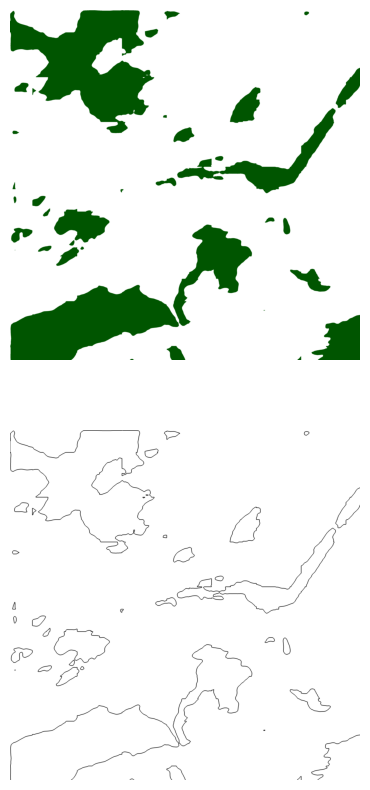

In [ ]:
# Original image
img = cv2.imread("/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000/output_10.png")
# Binary mask
binary_mask = np.where((cv2.imread("/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/final/output_10.tif",cv2.IMREAD_GRAYSCALE))>0.5,1,0)*255

# Background for contour
background = np.ones((15000,15000))*255
# Find contour from binary mask
contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP , cv2.CHAIN_APPROX_SIMPLE)
# Create a green mask from binary mask
rgb_mask = np.stack((((binary_mask[0:4000,0:4000]/255-1)*(-255)).astype(np.uint8), ((binary_mask[0:4000,0:4000]/255-1.5)*(-255/1.5)).astype(np.uint8), ((binary_mask[0:4000,0:4000]/255-1)*(-255)).astype(np.uint8)), axis=2)


fig, axis = plt.subplots(2,1,figsize=(10,10))
axis[0].imshow(rgb_mask)
axis[1].imshow(cv2.drawContours(background, contours, -1, (0,255,0), 3)[0:4000,0:4000],cmap='gray')
axis[0].set_axis_off()
axis[1].set_axis_off()

### Figures

NO average

Average

Figures

- IMG17: Inferences-process

In [ ]:
try:
  del img, mask
except:
    pass
gc.collect()

0

In [ ]:
input_img_path = "/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000/output_1.png"
output_mask_path = "/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/13/output_1.tif"
img = cv2.imread(input_img_path)[:7500,:7500,:]/255.0
mask = cv2.imread(output_mask_path,cv2.IMREAD_GRAYSCALE)[:7500,:7500]/255
mask = np.where(mask>0.5,1,0)
bg = np.ones((7500,7500,3))

In [ ]:
# # MASK
# bg[3000:4000,:6000,:] = np.stack(((mask[3000:4000,:6000]-1)*(-1),(mask[3000:4000,:6000]-1.5)*(-1/1.5),(mask[3000:4000,:6000]-1)*(-1)), axis=2)
# bg[0:3000,:,:] = np.stack(((mask[0:3000,:]-1)*(-1),(mask[0:3000,:]-1.5)*(-1/1.5),(mask[0:3000,:]-1)*(-1)), axis=2)

# bg[3000:4000,5000:5100] = [0.7,0.2,0.2]
# bg[3000:4000,5900:6000] = [0.7,0.2,0.2]
# bg[3000:3100,5000:6000] = [0.7,0.2,0.2]
# bg[3900:4000,5000:6000] = [0.7,0.2,0.2]




# # IMG
# img[3000:4000,:6000,2] = img[3000:4000,:6000,2]+0.3
# img[3000:4000,:6000,1] = img[3000:4000,:6000,1]+0.3
# img[3000:4000,:6000,0] = img[3000:4000,:6000,0]+0.3
# img[0:3000,:,2] = img[0:3000,:,2] + 0.3
# img[0:3000,:,1] = img[0:3000,:,1] + 0.3
# img[0:3000,:,0] = img[0:3000,:,0] + 0.3

# img[3000:4000,5000:5100] = [0.7,0.2,0.2]
# img[3000:4000,5900:6000] = [0.7,0.2,0.2]
# img[3000:3100,5000:6000] = [0.7,0.2,0.2]
# img[3900:4000,5000:6000] = [0.7,0.2,0.2]

# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(img)
# axis[0].set_axis_off()
# axis[1].imshow(bg)
# axis[1].set_axis_off()

- IMG 18

In [ ]:
img_path = "/content/drive/MyDrive/ML/IMG18-No-Aver-Img.png"
mask_path = "/content/drive/MyDrive/ML/IMG18-No-Aver-Mask.png"
mask = cv2.imread(mask_path)/255
img = cv2.imread(img_path)/255

In [ ]:
# # Define box coordinates
# # x1, y1 = 170, 5   # top-left corner
# # x2, y2 = 220, 150   # bottom-right corner
# x1, y1 = 100, 180   # top-left corner
# x2, y2 = 220, 220   # bottom-right corner
# # Dash parameters
# dash_length = 5
# gap_length = 3
# pattern = dash_length + gap_length

# # Draw dashed top border
# for x in range(x1, x2, pattern):
#     mask[y1, x:x+dash_length] = [255, 0, 0]

# # Draw dashed bottom border
# for x in range(x1, x2, pattern):
#     mask[y2, x:x+dash_length] = [255, 0, 0]

# # Draw dashed left border
# for y in range(y1, y2, pattern):
#     mask[y:y+dash_length, x1] = [255, 0, 0]

# # Draw dashed right border
# for y in range(y1, y2, pattern):
#     mask[y:y+dash_length, x2] = [255, 0, 0]




# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(img)
# axis[1].imshow(mask)
# axis[0].set_axis_off()
# axis[1].set_axis_off()

- IMG 19

In [ ]:
input_img_path = "/content/drive/MyDrive/ML/Cantabria/Captura de pantalla 2025-08-18 124946.png"
img = cv2.imread(input_img_path)/255.0
print(img.shape)

(369, 366, 3)


In [ ]:
# # img[60:310,60:300] = [0,0,0]
# width = 4
# img[60:60+width,60:300] = [0.7,0,0]
# img[310-width:310, 60:300] = [0.7,0,0]
# img[60:310,60:60+width] = [0.7,0,0]
# img[60:310,300-width:300] = [0.7,0,0]

# img[0:width,0:250] = [0,0,0.7]
# img[250-width:250, 0:250] = [0,0,0.7]
# img[0:250,0:width] = [0,0,0.7]
# img[0:250,250-width:250] = [0,0,0.7]

# img[366-width:366,366-250:366] = [0,0,0.7]
# img[366-250-width:366-250, 366-250:366] = [0,0,0.7]
# img[366-250:366,366-250-width:366-250] = [0,0,0.7]
# img[366-250:366,366-width:366] = [0,0,0.7]

# # img[0:width,366-250:366] = [0,0,0.7]
# # img[366-250-width:366250, 0:250] = [0,0,0.7]
# # img[0:250,0:width] = [0,0,0.7]
# # img[0:250,250-width:250] = [0,0,0.7]


# # img[:250,:250] = np.stack((img[:250,:250,0],img[:250,:250,1],img[:250,:250,2]+0.2),axis=2)
# # img[:250,366-250:366] = np.stack((img[:250,366-250:366,0],img[:250,366-250:366,1]+0.2,img[:250,366-250:366,2]),axis=2)

# fig, axis = plt.subplots()
# axis.imshow(img)
# axis.set_axis_off()


- IMG 21

In [ ]:
# Load model
model = Deeplabv3()
# checkpoint = torch.load("/content/drive/MyDrive/ML/Weights/loveda_deeplabv3_2/deeplabv3_loveda_0.906_0.900_18.pt")
# checkpoint = torch.load("/content/drive/MyDrive/ML/Weights/jordan_deeplabv3_val2/best/deeplabv3_jordan_0.933_0.807_35.pt")
checkpoint = torch.load("/content/drive/MyDrive/ML/Weights/jordan/DeeplabV3_jordan_512_12.pt")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model.to("cuda")


# Load image
name = "output_1"
mask_path = f"/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/final/{name}.tif"
img_path = f"/content/drive/MyDrive/ML/Cantabria/Cantabria_3000x3000/{name}.png"
input_img = cv2.imread(img_path)[1000:6000,0:5000]
# mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)[1000:6000,0:5000]
# section =np.stack((((mask/255-1)*(-255)).astype(np.uint8), ((mask /255-1.5)*(-255/1.5)).astype(np.uint8), ((mask /255-1)*(-255)).astype(np.uint8)), axis=2)

# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(img)
# axis[0].set_axis_off()
# axis[1].imshow(section)
# axis[1].set_axis_off()

In [ ]:
# Calculate the x and y difference for padding
size = 800

dif_y = (np.round(input_img.shape[0]/size)*size-input_img.shape[0]).astype(int)
dif_x = (np.round(input_img.shape[1]/size)*size-input_img.shape[1]).astype(int)

# Make grid
x_list = np.array([i for i in range(np.round(input_img.shape[0]/size).astype(int))])
y_list = np.array([i for i in range(np.round(input_img.shape[1]/size).astype(int))])
X, Y = np.meshgrid(x_list,y_list)
XY = np.stack((X, Y), axis=-1).flatten().reshape(-1, 2)

# Create a bigger matrix to place the input image in the center
padding = 256
matrix_ones = np.ones((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 3))*255.0  # Create a ones matrix with a bigger size than the input image (-256, 256)
matrix_zeros_output = np.zeros((input_img.shape[0]+padding*2+dif_y, input_img.shape[1]+padding*2+dif_x, 1)) # Create a zeros matrix with a bigger size than the input image (-256, 256)
matrix_ones[padding:padding+input_img.shape[0], padding:padding+input_img.shape[1], :] = input_img  # Place the input image in the center of the matrix

In [ ]:
for idx, (x0, y0) in enumerate(XY):
    if idx%50==0:
      print(f"Processing image position: {idx+1}/{XY.shape[0]} - ({x0}, {y0})")
    # Image position:
    img_pos = np.array([x0, y0])
    input_img_slice = matrix_ones[img_pos[0]*size+padding:(img_pos[0]+1)*size+padding, img_pos[1]*size+padding:(img_pos[1]+1)*size+padding,:]
    # Resize and normalize the input image slice
    input_img_slice = cv2.resize(input_img_slice, (512, 512))/255.0
    # Convert to tensor and move to device
    input_img_slice = torch.tensor(np.transpose(input_img_slice, (2, 0, 1)), dtype=torch.float32)
    # Add batch dimension and move to device
    input_img_slice = input_img_slice.unsqueeze(0).to("cuda")

    # Prediction
    output = model(input_img_slice)
    output = np.transpose(output.cpu().detach().numpy()[-1], (1, 2, 0))
    output = np.expand_dims(cv2.resize(output, (size, size), interpolation=cv2.INTER_LINEAR), axis=-1)  # Resize the output to 1024x1024 and add a new axis for the channel

    # Add the centered output to the matrix
    matrix_zeros_output[img_pos[0]*size+padding:(img_pos[0]+1)*size+padding, img_pos[1]*size+padding:(img_pos[1]+1)*size+padding,:] += output

    torch.cuda.empty_cache()
    # With/without threshould (and remove padding)
temp = np.where(matrix_zeros_output> 0.5, 1, 0)[padding:(padding+input_img.shape[0]), padding:(padding+input_img.shape[1]), :]*255
final_output = np.squeeze(np.stack((((temp/255-1)*(-255)).astype(np.uint8), ((temp/255-1.5)*(-255/1.5)).astype(np.uint8), ((temp/255-1)*(-255)).astype(np.uint8)), axis=2))  # Convert to RGB format
# final_output = matrix_zeros_output[padding:(padding+input_img.shape[0]), padding:(padding+input_img.shape[1]), :]
del matrix_ones
del matrix_zeros_output
gc.collect
torch.cuda.empty_cache()

Processing image position: 1/36 - (0, 0)


In [ ]:
# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(input_img)
# axis[1].imshow(final_output)

In [ ]:
img = cv2.imread("/content/drive/MyDrive/ML/IMG18-No-Aver-Img.png")/255
mask = cv2.imread("/content/drive/MyDrive/ML/IMG18-No-Aver-Mask.png")/255

In [ ]:
# x1, y1 = 150, 200   # top-left corner
# x2, y2 = 300, 250   # bottom-right corner
x1, y1 = 25, 50   # top-left corner
x2, y2 = 75,150    # bottom-right corner
# Dash parameters
dash_length = 5
gap_length = 3
pattern = dash_length + gap_length

# Draw dashed top border
for x in range(x1, x2, pattern):
    mask[y1, x:x+dash_length] = [255, 0, 0]

# Draw dashed bottom border
for x in range(x1, x2, pattern):
    mask[y2, x:x+dash_length] = [255, 0, 0]

# Draw dashed left border
for y in range(y1, y2, pattern):
    mask[y:y+dash_length, x1] = [255, 0, 0]

# Draw dashed right border
for y in range(y1, y2, pattern):
    mask[y:y+dash_length, x2] = [255, 0, 0]

In [ ]:
# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(img)
# axis[0].set_axis_off()
# axis[1].imshow(mask)
# axis[1].set_axis_off()

In [ ]:
# # Average mask comparison
# avg_mask = cv2.imread("/content/drive/MyDrive/ML/Masks/Loveda_multi_mask/final/output_1.tif",cv2.IMREAD_GRAYSCALE)[1000:6000,0:5000]/255
# avg_mask = np.where(avg_mask>0.5,1,0)
# final_avg_mask = np.stack(((avg_mask-1)*(-1),(avg_mask-1.5)*(-1/1.5),(avg_mask-1)*(-1)),axis=2)
# fig, axis = plt.subplots(1,2,figsize=(10,10))
# axis[0].imshow(mask)
# axis[0].set_axis_off()
# axis[1].imshow(final_avg_mask)
# axis[1].set_axis_off()

- IMG 22 powerline